In [13]:
from dataclasses import replace
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import os.path
import sys
import logging
import pickle
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from models.garnet_trigger import GNNGraphClassifier
from icecream import ic
from numpy.linalg import inv
import sklearn.metrics as metrics
from datasets import get_data_loaders
from tqdm.notebook import tqdm
import glob
from importlib import reload

In [14]:
DEVICE = "cuda:0"

In [15]:
# create model and load checkpoint
model_result_folder = '/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger_results/agnn/agnn-lr8.19806576478371e-05-b12-d71-PReLU-gi1-ln-True-n1600000/experiment_2024-04-26_13:41:37'
config_file = model_result_folder + '/config.pkl'
config = pickle.load(open(config_file, 'rb'))
data_config = config.get('data')
dphi_max, dz_max = data_config['phi_slope_max'], data_config['z0_max']


In [16]:
data_config

{'batch_size': 12,
 'construct_edges': False,
 'input_dir': '/ssd3/giorgian/hits-data-march-2024/trigger/1/',
 'input_dir2': '/ssd2/giorgian/hits-data-august-2022/nontrigger/0/',
 'load_full_event': False,
 'n_folders': 2,
 'n_mix': 10,
 'n_train': 800000,
 'n_valid': 175000,
 'n_workers': 16,
 'name': 'hit_graph_trigger_pileup',
 'phi_slope_max': 0.012193355583173944,
 'real_weight': 1,
 'z0_max': 14.220353082111805}

In [17]:
data_config['n_train'] = 1000
data_config['n_valid'] = 1
data_config['batch_size'] = 1

In [18]:
data_config

{'batch_size': 1,
 'construct_edges': False,
 'input_dir': '/ssd3/giorgian/hits-data-march-2024/trigger/1/',
 'input_dir2': '/ssd2/giorgian/hits-data-august-2022/nontrigger/0/',
 'load_full_event': False,
 'n_folders': 2,
 'n_mix': 10,
 'n_train': 1000,
 'n_valid': 1,
 'n_workers': 16,
 'name': 'hit_graph_trigger_pileup',
 'phi_slope_max': 0.012193355583173944,
 'real_weight': 1,
 'z0_max': 14.220353082111805}

In [19]:
hits = {}

In [20]:
train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)

n_hits = []
for batch in tqdm(train_data_loader):
    n_hits.append(batch.x.shape[0])
hits[()] = n_hits

  0%|          | 0/2000 [00:00<?, ?it/s]

In [21]:
n_hits

[600,
 593,
 547,
 614,
 759,
 570,
 636,
 857,
 629,
 639,
 553,
 653,
 705,
 976,
 736,
 689,
 647,
 730,
 540,
 379,
 710,
 618,
 498,
 706,
 598,
 682,
 940,
 577,
 753,
 627,
 832,
 597,
 595,
 788,
 534,
 692,
 568,
 699,
 514,
 505,
 502,
 619,
 847,
 558,
 483,
 740,
 606,
 597,
 625,
 623,
 635,
 806,
 679,
 694,
 797,
 854,
 668,
 620,
 870,
 768,
 646,
 545,
 652,
 421,
 435,
 566,
 959,
 943,
 774,
 483,
 517,
 694,
 793,
 578,
 740,
 772,
 642,
 569,
 709,
 551,
 625,
 808,
 835,
 669,
 553,
 610,
 608,
 259,
 452,
 566,
 721,
 592,
 507,
 561,
 540,
 732,
 695,
 636,
 702,
 733,
 618,
 713,
 875,
 472,
 801,
 558,
 1065,
 794,
 824,
 712,
 890,
 922,
 901,
 788,
 590,
 553,
 672,
 574,
 562,
 641,
 702,
 702,
 727,
 918,
 378,
 652,
 377,
 681,
 746,
 645,
 835,
 660,
 662,
 581,
 757,
 659,
 779,
 802,
 650,
 435,
 625,
 733,
 687,
 621,
 410,
 568,
 600,
 610,
 580,
 501,
 660,
 636,
 533,
 616,
 801,
 575,
 459,
 826,
 680,
 657,
 889,
 651,
 690,
 921,
 989,
 918,
 78

In [39]:
data_config['drop_l1'] = True
data_config['drop_l2'] = False
data_config['drop_l3'] = False
data_config['intt_filter'] = True
train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)
n_hits = []
for batch in tqdm(train_data_loader):
    n_hits.append(batch.x.shape[0])
hits[(1,)] = n_hits

  0%|          | 0/2000 [00:00<?, ?it/s]

In [40]:
data_config['drop_l1'] = True
data_config['drop_l2'] = True
data_config['drop_l3'] = False
train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)
n_hits = []
for batch in tqdm(train_data_loader):
    n_hits.append(batch.x.shape[0])
hits[(1,2)] = n_hits

  0%|          | 0/2000 [00:00<?, ?it/s]

In [41]:
data_config['drop_l1'] = True
data_config['drop_l2'] = True
data_config['drop_l3'] = True
train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)
n_hits = []
for batch in tqdm(train_data_loader):
    n_hits.append(batch.x.shape[0])
hits[(1,2,3)] = n_hits

  0%|          | 0/2000 [00:00<?, ?it/s]

In [42]:
data_config['drop_l1'] = True
data_config['drop_l2'] = False
data_config['drop_l3'] = True
train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)
n_hits = []
for batch in tqdm(train_data_loader):
    n_hits.append(batch.x.shape[0])
hits[(1,3)] = n_hits

  0%|          | 0/2000 [00:00<?, ?it/s]

In [43]:
data_config['drop_l1'] = False
data_config['drop_l2'] = False
data_config['drop_l3'] = False
data_config['intt_filter'] = False

train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)
n_hits = []
for batch in tqdm(train_data_loader):
    n_hits.append(batch.x.shape[0])
hits[()] = n_hits

  0%|          | 0/2000 [00:00<?, ?it/s]

In [44]:
for k, v in hits_filtered.items():
    print(f'{k}: mean={np.mean(v)}, max={np.max(v)}')

(): mean=658.775, max=1104
(1,): mean=119.758, max=372
(1, 2): mean=119.267, max=362
(1, 2, 3): mean=104.1445, max=357
(1, 3): mean=119.1105, max=383


In [36]:
hits_filetered = hits

In [38]:
for k, v in hits_unfiltered.items():
    print(f'{k}: mean={np.mean(v)}, max={np.max(v)}')

(): mean=656.138, max=1173
(1,): mean=469.376, max=923
(1, 2): mean=290.74, max=540
(1, 2, 3): mean=104.153, max=357
(1, 3): mean=301.0345, max=593


In [40]:
n_intt = []
for event in tqdm(glob.glob('/ssd3/giorgian/hits-data-march-2024/trigger/1/*.npz')):
    f = np.load(event)
    l = f['layer_id']
    n_intt.append(np.sum(l > 3))

  0%|          | 0/994440 [00:00<?, ?it/s]

(array([1.04000e+02, 6.78000e+02, 3.20100e+03, 7.07500e+03, 1.37120e+04,
        3.40320e+04, 3.95270e+04, 7.11060e+04, 6.53650e+04, 7.16970e+04,
        1.00009e+05, 7.47120e+04, 9.45810e+04, 6.49890e+04, 5.85260e+04,
        6.70310e+04, 4.24850e+04, 4.70290e+04, 2.82390e+04, 2.35810e+04,
        2.45200e+04, 1.41210e+04, 1.45310e+04, 8.08900e+03, 6.42100e+03,
        6.21500e+03, 3.39800e+03, 3.20100e+03, 1.65400e+03, 1.29700e+03,
        1.15200e+03, 5.99000e+02, 5.72000e+02, 2.97000e+02, 2.27000e+02,
        1.73000e+02, 7.70000e+01, 8.70000e+01, 4.10000e+01, 1.90000e+01,
        2.80000e+01, 9.00000e+00, 1.30000e+01, 6.00000e+00, 5.00000e+00,
        4.00000e+00, 1.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0. ,   3.4,   6.8,  10.2,  13.6,  17. ,  20.4,  23.8,  27.2,
         30.6,  34. ,  37.4,  40.8,  44.2,  47.6,  51. ,  54.4,  57.8,
         61.2,  64.6,  68. ,  71.4,  74.8,  78.2,  81.6,  85. ,  88.4,
         91.8,  95.2,  98.6, 102. , 105.4, 108.8, 112.2

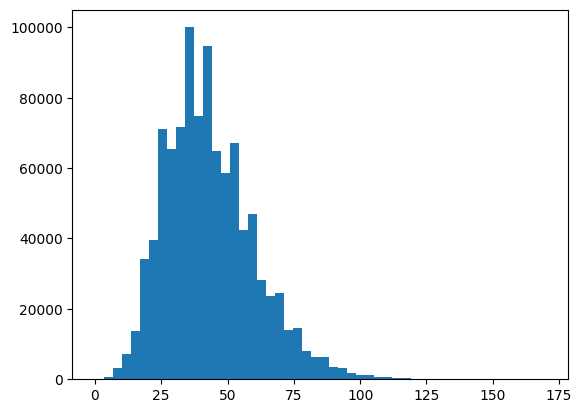

In [45]:
plt.hist(n_intt, bins=50)

In [46]:
n_intt = np.array(n_intt)

In [48]:
np.sum(n_intt == 0)/n_intt.shape[0]

3.0167732593218295e-06

In [52]:
reload(datasets.hit_graph_trigger_pileup)

NameError: name 'datasets' is not defined

In [6]:
from datasets.hit_graph_trigger_pileup import intt_mask, load_file

In [7]:
files = glob.glob('/ssd3/giorgian/hits-data-march-2024/trigger/1/*.npz')

In [23]:
intt_event = load_file(files[0])
pileup_event = load_file(files[1])
pileup_event = intt_event

In [24]:
g = intt_mask(intt_event, pileup_event, data_config['phi_slope_max'], data_config['z0_max'])

good_seg_mask.shape=(107, 46)
intt_hits.shape=(46, 3)
mvtx_hits.shape=(107, 3)


/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/tracking-GNN/datasets/hit_graph_trigger_pileup.py:161: RuntimeWarning: invalid value encountered in divide
  phi_slope = dphi / dr
/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/tracking-GNN/datasets/hit_graph_trigger_pileup.py:162: RuntimeWarning: invalid value encountered in divide
  z0 = z1 - r1 * dz / dr


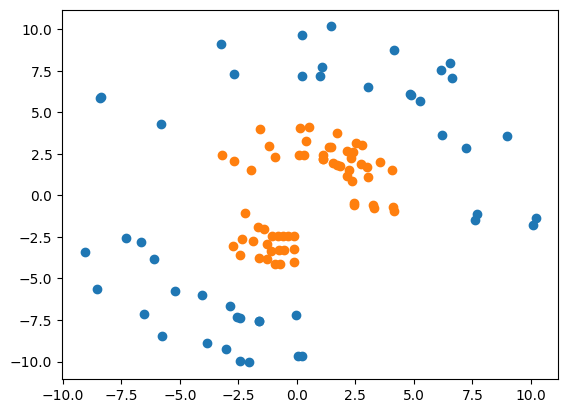

In [27]:
m = intt_event.layer_id >= 3
plt.scatter(intt_event.hit_cartesian[:, 0][m], intt_event.hit_cartesian[:, 1][m])

m = pileup_event.layer_id < 3
plt.scatter(pileup_event.hit_cartesian[:, 0][m], pileup_event.hit_cartesian[:, 1][m])

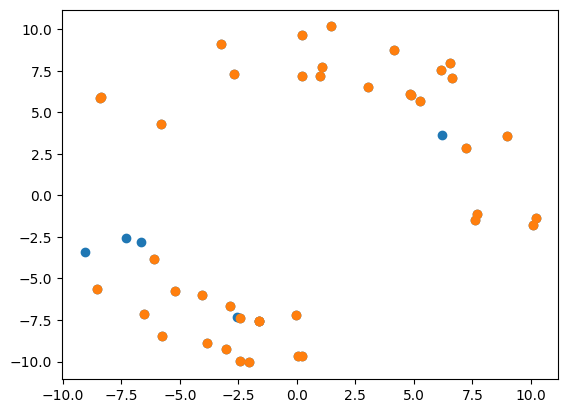

In [29]:
m = intt_event.layer_id >= 3
plt.scatter(intt_event.hit_cartesian[:, 0][m], intt_event.hit_cartesian[:, 1][m])

#m = pileup_event.layer_id < 3
#plt.scatter(pileup_event.hit_cartesian[:, 0][m], pileup_event.hit_cartesian[:, 1][m])

m = np.any(g, axis=1) & m
plt.scatter(pileup_event.hit_cartesian[:, 0][m], pileup_event.hit_cartesian[:, 1][m])
